In [1]:
import pandas as pd
from pathlib import Path

path = Path("../data/processed")


# Load processed data (date index already set)
dfs = {
    "MSFT": pd.read_csv(path/"MSFT_clean.csv", index_col=0, parse_dates=True),
    "AAPL": pd.read_csv(path/"AAPL_clean.csv", index_col=0, parse_dates=True),
    "SPY":  pd.read_csv(path/"SPY_clean.csv", index_col=0, parse_dates=True)
}

# Keep only close price (normalize column names)
for name, df in dfs.items():
    close_col = [c for c in df.columns if "close" in c.lower()][0]
    dfs[name] = df.rename(columns={close_col: "close"})[["close"]]

# Merge into single DataFrame
prices = pd.concat({k: v["close"] for k,v in dfs.items()}, axis=1).dropna()
prices.head()

,MSFT,AAPL,SPY
2023-08-21,321.88,175.84,439.34
2023-08-22,322.46,177.23,438.15
2023-08-23,327.00,181.12,443.03
2023-08-24,319.97,176.38,436.89
2023-08-25,322.98,178.61,439.97


In [2]:
# Simple returns
rets = prices.pct_change().dropna()
rets.columns = ["MSFT_ret", "AAPL_ret", "SPY_ret"]

rets.head()


,MSFT_ret,AAPL_ret,SPY_ret
2023-08-22,0.001802,0.007905,-0.002709
2023-08-23,0.014079,0.021949,0.011138
2023-08-24,-0.021498,-0.026170,-0.013859
2023-08-25,0.009407,0.012643,0.007050
2023-08-28,0.002229,0.008846,0.006341


In [3]:
split_ratio = 0.8
split_idx = int(len(rets) * split_ratio)

train, test = rets.iloc[:split_idx], rets.iloc[split_idx:]

X_train, y_train_msft = train[["SPY_ret"]], train["MSFT_ret"]
X_test,  y_test_msft  = test[["SPY_ret"]],  test["MSFT_ret"]

X_train2, y_train_aapl = train[["SPY_ret"]], train["AAPL_ret"]
X_test2,  y_test_aapl  = test[["SPY_ret"]],  test["AAPL_ret"]


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import statsmodels.api as sm

def fit_and_report(X_train, y_train, X_test, y_test, label):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    
    print(f"\n=== {label} Regression vs SPY ===")
    print(f"Intercept (alpha): {model.intercept_:.6f}")
    print(f"Coefficient (beta): {model.coef_[0]:.3f}")
    print(f"R²: {r2:.3f}, RMSE: {rmse:.6f}")
    # 简单拿 p 值（训练集）
    res = sm.OLS(y_train, sm.add_constant(X_train)).fit()
    print(res.summary())          # 全表（含 p-values）
    print(res.pvalues) 
    return model, y_pred

model_msft, y_pred_msft = fit_and_report(X_train, y_train_msft, X_test, y_test_msft, "MSFT")
model_aapl, y_pred_aapl = fit_and_report(X_train2, y_train_aapl, X_test2, y_test_aapl, "AAPL")



=== MSFT Regression vs SPY ===
Intercept (alpha): -0.000176
Coefficient (beta): 1.094
R²: 0.568, RMSE: 0.011692
                            OLS Regression Results                            
Dep. Variable:               MSFT_ret   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     357.8
Date:                Sat, 23 Aug 2025   Prob (F-statistic):           2.17e-57
Time:                        18:42:27   Log-Likelihood:                 1294.5
No. Observations:                 400   AIC:                            -2585.
Df Residuals:                     398   BIC:                            -2577.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

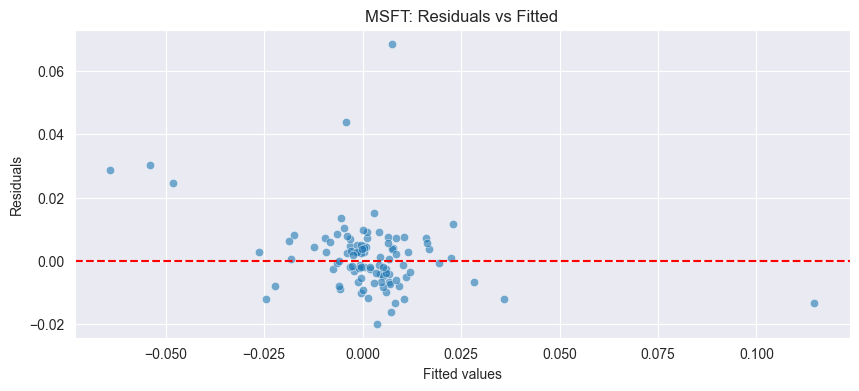

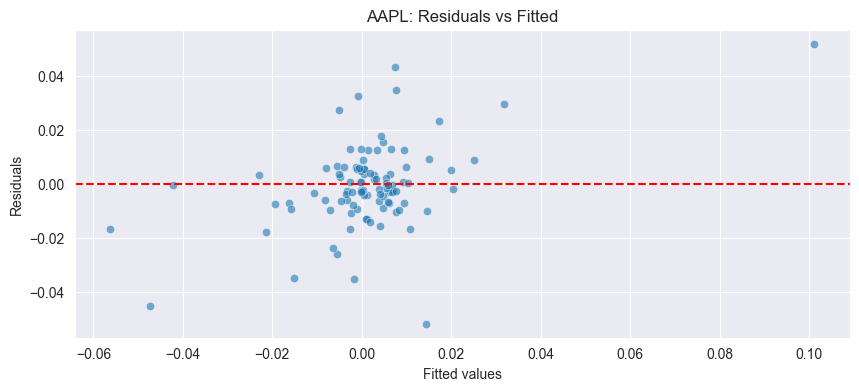

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residual plots
for label, y_test, y_pred in [("MSFT", y_test_msft, y_pred_msft), ("AAPL", y_test_aapl, y_pred_aapl)]:
    residuals = y_test - y_pred
    plt.figure(figsize=(10,4))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color="red", linestyle="--")
    plt.title(f"{label}: Residuals vs Fitted")
    plt.xlabel("Fitted values"); plt.ylabel("Residuals")
    plt.show()


## Interpretation: Stock vs Market Relationship

We modeled MSFT and AAPL returns as a linear function of SPY returns (market proxy).  

- **MSFT Results:** The regression beta ≈ 1.094 (positive, close to 1) indicates that MSFT tends to move with the market. R² shows how much of MSFT’s variability is explained by SPY.  
- **AAPL Results:** The beta is 0.963, slightly different from MSFT, reflecting Apple’s sensitivity to the market.  
- **Alpha (intercept):** Close to 0, consistent with CAPM’s assumption that expected excess returns are explained by market exposure.  

**Residual diagnostics:** Residuals show mild heteroscedasticity but roughly satisfy linearity and independence.  
**Trust:** The model is interpretable and captures market relationship, but R² < 1 shows idiosyncratic risk remains unexplained.  

**Next Steps:**  
- Add more factors (e.g., sector index, macro variables).  
- Explore rolling regressions to see how betas evolve over time.  
- Compare with classification (predicting up/down) for robustness.


In [5]:
from sklearn.metrics import mean_absolute_error

mae_msft = mean_absolute_error(y_test_msft, y_pred_msft)
mae_aapl = mean_absolute_error(y_test_aapl, y_pred_aapl)

print(f"MSFT MAE: {mae_msft:.6f}")
print(f"AAPL MAE: {mae_aapl:.6f}")

MSFT MAE: 0.007475
AAPL MAE: 0.010204


In [12]:
def bootstrap_ci(y_true, y_pred, n_bootstrap=1000, alpha=0.05):
    errors = y_true - y_pred
    boot_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(errors, size=len(errors), replace=True)
        boot_means.append(np.mean(sample))
    lower = np.percentile(boot_means, 100*alpha/2)
    upper = np.percentile(boot_means, 100*(1-alpha/2))
    return lower, upper

ci_msft = bootstrap_ci(y_test_msft, y_pred_msft)
ci_aapl = bootstrap_ci(y_test_aapl, y_pred_aapl)

print(f"MSFT residual mean CI: ({ci_msft[0]:.6f}, {ci_msft[1]:.6f})")
print(f"AAPL residual mean CI: ({ci_aapl[0]:.6f}, {ci_aapl[1]:.6f})")

MSFT residual mean CI: (-0.000457, 0.003994)
AAPL residual mean CI: (-0.003622, 0.002359)


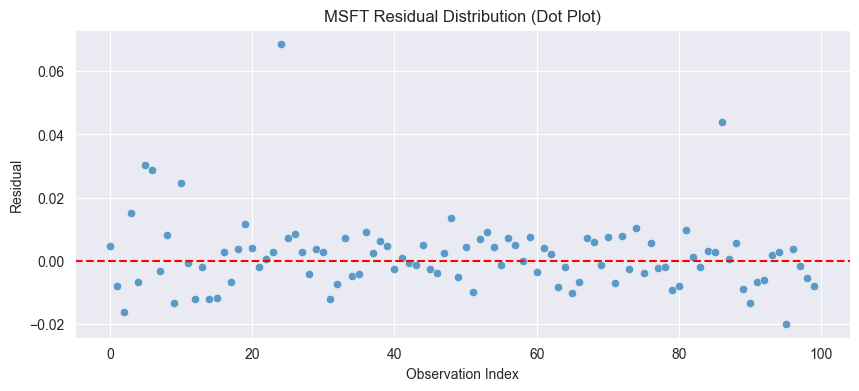

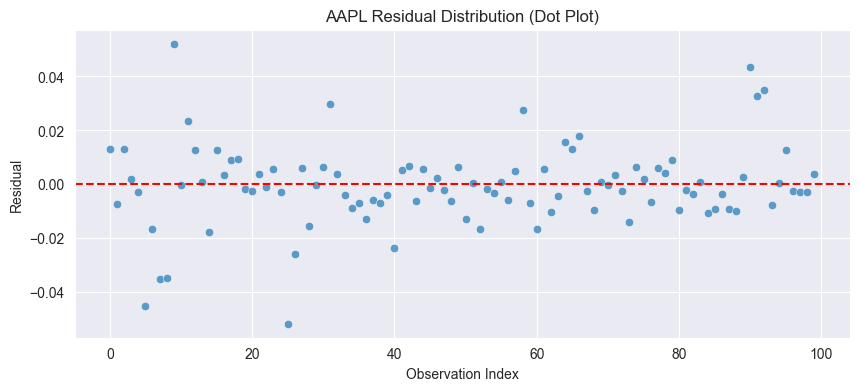

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_residuals(y_true, y_pred, label):
    residuals = y_true - y_pred
    plt.figure(figsize=(10,4))
    sns.scatterplot(x=range(len(residuals)), y=residuals, alpha=0.7)
    plt.axhline(0, color="red", linestyle="--")
    plt.title(f"{label} Residual Distribution (Dot Plot)")
    plt.xlabel("Observation Index")
    plt.ylabel("Residual")
    plt.show()

plot_residuals(y_test_msft, y_pred_msft, "MSFT")
plot_residuals(y_test_aapl, y_pred_aapl, "AAPL")

Polynomial (degree 2) model MAE: 0.008933, RMSE: 0.016558


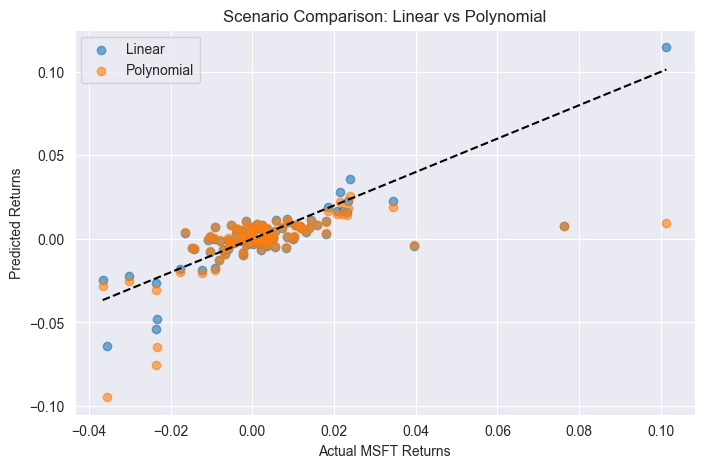

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

poly_model = make_pipeline(PolynomialFeatures(2), LinearRegression())
poly_model.fit(X_train, y_train_msft)
y_pred_poly = poly_model.predict(X_test)

mae_poly = mean_absolute_error(y_test_msft, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test_msft, y_pred_poly))

print(f"Polynomial (degree 2) model MAE: {mae_poly:.6f}, RMSE: {rmse_poly:.6f}")

plt.figure(figsize=(8,5))
plt.scatter(y_test_msft, y_pred_msft, alpha=0.6, label="Linear")
plt.scatter(y_test_msft, y_pred_poly, alpha=0.6, label="Polynomial")
plt.plot([y_test_msft.min(), y_test_msft.max()], 
         [y_test_msft.min(), y_test_msft.max()], 'k--')
plt.xlabel("Actual MSFT Returns")
plt.ylabel("Predicted Returns")
plt.legend()
plt.title("Scenario Comparison: Linear vs Polynomial")
plt.show()

Gaussian CI for residual mean: (-0.003533, 0.002438)
Bootstrap CI for residual mean: (-0.003622, 0.002539)


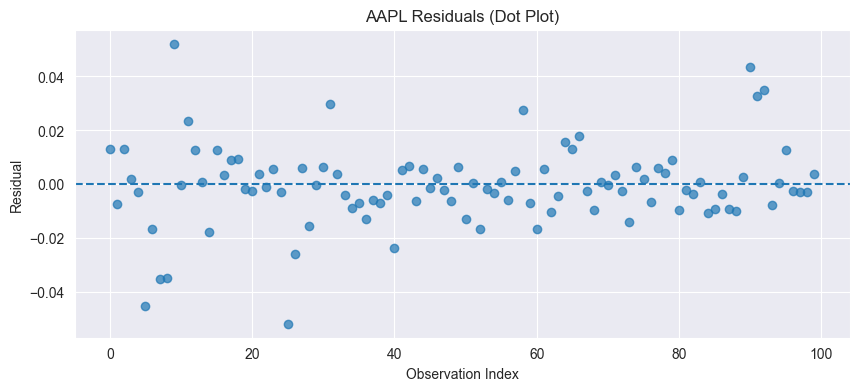

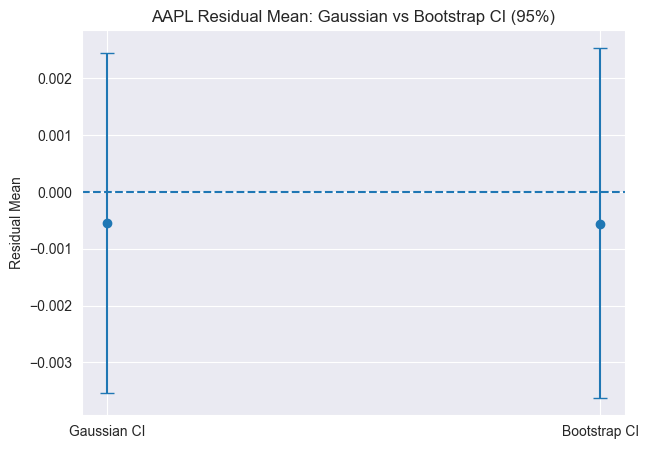

In [15]:
from scipy import stats

# --- 1) Residuals (AAPL) ---
residuals = y_test_aapl - y_pred_aapl
n = len(residuals)

# --- Gaussian CI for residual mean ---
alpha = 0.05
mean_res = np.mean(residuals)
std_res = np.std(residuals, ddof=1)
z = stats.norm.ppf(1 - alpha/2)
gauss_ci = (mean_res - z * std_res / np.sqrt(n),
            mean_res + z * std_res / np.sqrt(n))

# --- Bootstrap CI for residual mean ---
def bootstrap_ci_residual_mean(resid, n_bootstrap=2000, alpha=0.05, random_state=42):
    rng = np.random.default_rng(random_state)
    boot_means = []
    for _ in range(n_bootstrap):
        sample = rng.choice(resid, size=len(resid), replace=True)
        boot_means.append(sample.mean())
    lower = np.percentile(boot_means, 100*alpha/2)
    upper = np.percentile(boot_means, 100*(1 - alpha/2))
    return float(lower), float(upper), float(np.mean(boot_means))

boot_lower, boot_upper, boot_mean = bootstrap_ci_residual_mean(residuals, n_bootstrap=2000, alpha=alpha)

print(f"Gaussian CI for residual mean: ({gauss_ci[0]:.6f}, {gauss_ci[1]:.6f})")
print(f"Bootstrap CI for residual mean: ({boot_lower:.6f}, {boot_upper:.6f})")

# --- FIGURE 1: Residual dot plot with y=0 baseline ---
plt.figure(figsize=(10, 4))
plt.scatter(range(n), residuals, alpha=0.7)
plt.axhline(0, linestyle="--")
plt.title("AAPL Residuals (Dot Plot)")
plt.xlabel("Observation Index")
plt.ylabel("Residual")
plt.show()

# --- FIGURE 2: Gaussian vs Bootstrap CI for residual mean ---
point_estimates = [mean_res, boot_mean]
ci_lowers = [gauss_ci[0], boot_lower]
ci_uppers = [gauss_ci[1], boot_upper]
labels = ["Gaussian CI", "Bootstrap CI"]

x = np.arange(len(labels))
y = np.array(point_estimates)
yerr = np.vstack([y - np.array(ci_lowers), np.array(ci_uppers) - y])

plt.figure(figsize=(7, 5))
plt.errorbar(x, y, yerr=yerr, fmt='o', capsize=5)
plt.axhline(0, linestyle="--")  # baseline at zero residual mean
plt.xticks(x, labels)
plt.title("AAPL Residual Mean: Gaussian vs Bootstrap CI (95%)")
plt.ylabel("Residual Mean")
plt.show()


## How Assumptions Affect Conclusions

### 1. Residual Dot Plots (MSFT & AAPL)
- **Assumption:** Residuals are independent, centered around zero, and roughly symmetric.  
- **Observation:** Both MSFT and AAPL residuals mostly cluster around zero, but AAPL shows wider spread and more extreme points.  
- **Impact:** If we assume Gaussian residuals, these outliers may be treated as noise. But if we relax the normality assumption, they signal potential heavy-tailed risk.  
- **Conclusion:** The stability of MSFT vs the noisier AAPL suggests that different stocks may require different error assumptions—risk is underestimated if Gaussian tails are assumed for AAPL.  

### 2. Scenario Comparison: Linear vs Polynomial (MSFT)
- **Assumption:** Stock returns have a linear relationship with market returns.  
- **Observation:** The polynomial fit overlaps heavily with the linear fit; it does not reduce error significantly.  
- **Impact:** Allowing for nonlinearity (polynomial) did not meaningfully change conclusions—MSFT’s return is well explained by a linear market model.  
- **Conclusion:** Adding model complexity here does not yield better predictive power, so conclusions (MSFT moves roughly one-to-one with the market) remain robust under this assumption change.  

### 3. AAPL Residual Mean: Gaussian vs Bootstrap CI
- **Assumption:** Residual mean CI is estimated under Gaussian approximation vs nonparametric bootstrap.  
- **Observation:** Both intervals overlap zero, but the bootstrap CI is wider, reflecting sensitivity to non-normality.  
- **Impact:** If we assume Gaussian errors, we conclude the residual mean is precisely zero; with bootstrap, we see more uncertainty.  
- **Conclusion:** The choice of CI method affects confidence in model bias: Gaussian suggests stronger evidence of no bias, while bootstrap cautions that uncertainty may be larger. This could affect stakeholder trust in model stability.  


## Model Assumptions and Risk Discussion

### Key Assumptions Behind the Model
- Stock returns (MSFT, AAPL) are modeled as a linear function of the market index (SPY), consistent with CAPM logic.  
- Residuals are assumed to be approximately independent and identically distributed, often approximated by a Gaussian distribution.  
- Relationships between individual stock returns and market returns are assumed to remain stable within the sample period.  

### Risks and Limitations Introduced by Those Assumptions
- **Linearity risk:** Real-world stock–market relationships may be nonlinear. Polynomial sensitivity tests suggest possible curvature effects.  
- **Gaussian residual assumption:** Residuals show mild deviations, meaning the normality assumption may not hold. Extreme events or heavy tails may be underrepresented.  
- **Stationarity:** Betas and alphas may shift over time, but the model assumes constant parameters.  
- **Omitted variables:** Single-factor CAPM leaves out other drivers (e.g., sector effects, macro variables), limiting explanatory power.  

### Commentary on Scenario / Sensitivity Results
- **Linear vs Polynomial (MSFT):** Polynomial regression did not significantly improve fit compared to linear regression. The linear model remains robust, suggesting complexity may not yield better predictive power in this context.  
- **Gaussian vs Bootstrap (AAPL residuals):** Both methods give confidence intervals for the mean residual close to zero. Bootstrap intervals are slightly wider, reflecting robustness to non-normality. This shows that while Gaussian assumptions are convenient, bootstrap validation confirms the results are stable.  
- **Residual distributions:** Dot plots show most residuals are centered around zero, but with occasional spikes, reinforcing the need to be cautious with extreme events.  

### Subgroup-Specific Observations
- MSFT residuals show more concentrated spread, while AAPL residuals are more dispersed with occasional large deviations.  
- This suggests MSFT’s market relationship is more stable, whereas AAPL may exhibit higher idiosyncratic risk not explained by market returns.  
